In [1]:
SensorNum=2 # Sensor number
WindowWidth=[16,32,64,128,256,512,1024] # Window Width
OverlapArray=[4,8,16,32,64,128,256] # sliding window
width=3000 # graph width 
EncodingDim=[4,8,12,16,32,64] # number of hidden layer note
Axis='AccY' # Axis

# chopin
#WORKSPACE_PATH = "/media/takeyama/HD-PZU3/01_TAKEYAMA_WORKSPACE/02_CommonData/2016-07-25"

# mozart
WORKSPACE_PATH = "/home/takeyama/Documents/01_SyncChopin"

In [2]:
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import signal
import time
import os
import matplotlib
import matplotlib.pyplot as plt
import pylab
import pickle
import copy
import processing
import datetime
import multiprocessing as mp
import processing

%matplotlib inline

In [3]:
DataName='sensor'+str(SensorNum)+'_'+Axis
SensorName='sensor'+str(SensorNum)
DicName='MemSensor'+str(SensorNum)

In [4]:
if not os.path.exists(WORKSPACE_PATH+'/study/'+DataName+'/'): os.makedirs(WORKSPACE_PATH+'/study/'+DataName+'/')
StudyDataPath=WORKSPACE_PATH+'/study/'+DataName+'/'

if not os.path.exists(WORKSPACE_PATH+'/graph/'+DataName+'/loss/'): os.makedirs(WORKSPACE_PATH+'/graph/'+DataName+'/loss/')
GraphDataPath=WORKSPACE_PATH+'/graph/'+DataName+'/loss/'

if not os.path.exists(WORKSPACE_PATH+'/graph/'+DataName+'/Time/'): os.makedirs(WORKSPACE_PATH+'/graph/'+DataName+'/Time/')
GraphDataTimePath=WORKSPACE_PATH+'/graph/'+DataName+'/Time/'

if not os.path.exists(WORKSPACE_PATH+'/graph/'+DataName+'/Spectrum_Phase/'): os.makedirs(WORKSPACE_PATH+'/graph/'+DataName+'/Spectrum_Phase/')
GraphDataSpectrumPath=WORKSPACE_PATH+'/graph/'+DataName+'/Spectrum_Phase/'

if not os.path.exists(WORKSPACE_PATH+'/modelPic/'+DataName+'/'): os.makedirs(WORKSPACE_PATH+'/modelPic/'+DataName+'/')
StudyDataModelPicPath=WORKSPACE_PATH+'/modelPic/'+DataName+'/'

if not os.path.exists(WORKSPACE_PATH+'/window/'+DataName+'/'): os.makedirs(WORKSPACE_PATH+'/window/'+DataName+'/')
WindowDataPath=WORKSPACE_PATH+'/window/'+DataName+'/'

RawDataPath=WORKSPACE_PATH+"raw/"

In [5]:
def kld(p, q):
    """Calculates Kullback–Leibler divergence"""
    p = np.array(p)
    q = np.array(q)
    return np.sum(p * np.log(p / q), axis=(p.ndim - 1))
 
def jsd(p, q):
    """Calculates Jensen-Shannon Divergence"""
    p = np.array(p)
    q = np.array(q)
    m = 0.5 * (p + q)
    return 0.5 * kld(p, m) + 0.5 * kld(q, m)

hiden node = 4
calcurate FFT
calcurate Phase


TypeError: cannot concatenate 'str' and 'int' objects

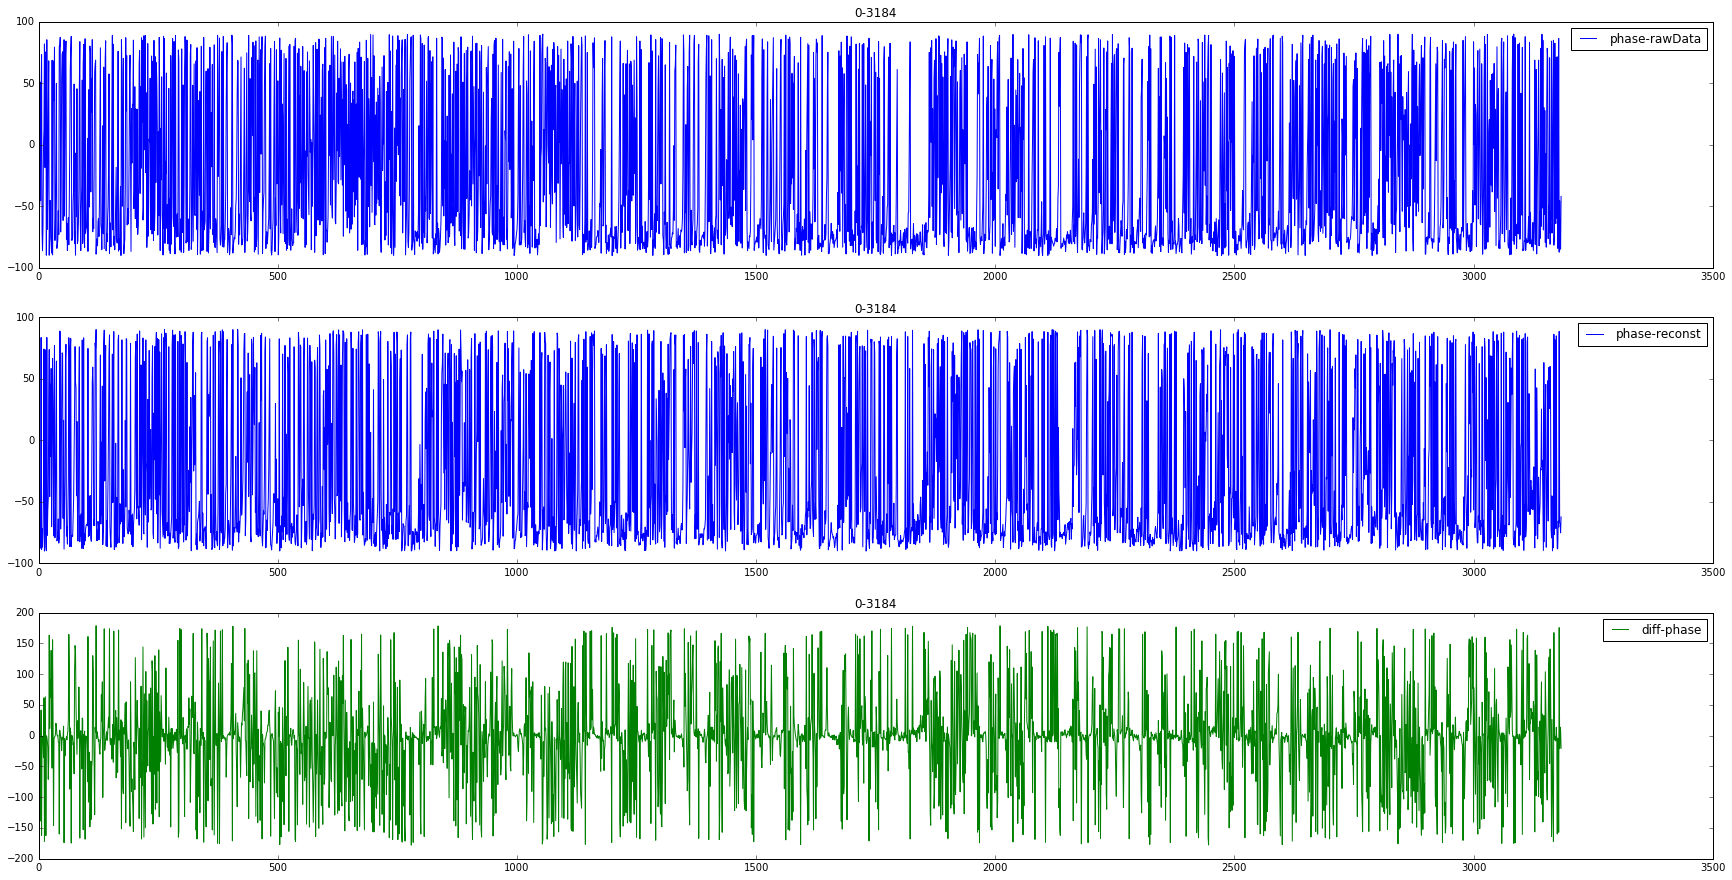

In [6]:
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(311)
bx = fig.add_subplot(312)
cx = fig.add_subplot(313)

# loop windowWidth
for SampleNum,Overlap in zip(WindowWidth,OverlapArray):
    # define SaveFileName
    for encoding_dim in EncodingDim:
        print "hiden node = "+str(encoding_dim)
        CommonName = '_edim='+str(encoding_dim)+'-Window='+str(SampleNum)+'-Overlap='+str(Overlap*100)
        SaveFileNameEncord=DataName+'_encoded'+ CommonName
        SaveFileNameDecord=DataName+'_decoded'+ CommonName
        SaveFileNameNet=DataName+'_net'+ CommonName
        SaveFileNameTrain=DataName+'_train'+ CommonName
        SaveFileNameTest=DataName+'_test'+ CommonName
        SaveFileNameGraph= GraphDataSpectrumPath+DataName+CommonName

        #window = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameTrain)
        window = processing.LoadDicDataFromFileNPZ(WindowDataPath+SaveFileNameTrain)
        reconstructData = processing.LoadDicDataFromFileNPZ(StudyDataPath+SaveFileNameDecord)
        
        # FFT 
        print "calcurate FFT"
        fftDataE = np.array([])
        fftDataD = np.array([])
        for i in range(len(window)):
                fftDataE=np.append(fftDataE, fftpack.fft( window[i])[1:(SampleNum/2)+1])
                fftDataD=np.append(fftDataD, fftpack.fft( reconstructData[i])[1:(SampleNum/2)+1])
        fftDataE = fftDataE.reshape(len(fftDataE)/(SampleNum/2),(SampleNum/2))
        fftDataD = fftDataD.reshape(len(fftDataD)/(SampleNum/2),(SampleNum/2))
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-fft-raw',fftDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-fft-restruct',fftDataD)
        
        # Phase
        print "calcurate Phase"
        phaseDataE = np.arctan(np.imag(fftDataE)/np.real(fftDataE)) * 180/np.pi
        phaseDataD = np.arctan(np.imag(fftDataD)/np.real(fftDataD)) * 180/np.pi

        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-phase-raw',phaseDataE)
        processing.SaveDicDataFromFileNPZ(StudyDataPath, DataName+CommonName+'-phase-restruct',phaseDataD)
        
        width = phaseDataE.shape[0]/20
        for l in range(0,SampleNum/2):
            for i in range(width,phaseDataE.shape[0],width):
                start =i-width
                goal=i

                data = phaseDataD[start:goal,l]-phaseDataE[start:goal,l]
                dataE = phaseDataE[start:goal,l]
                dataD = phaseDataD[start:goal,l]

                #dataE,dataDをPower
                ax.plot(range(start,goal),dataE ,label='phase-rawData')
                ax.legend(loc='best')
                ax.set_title(str(start)+"-"+str(goal))

                bx.plot(range(start,goal),dataD,label='phase-reconst' )
                bx.legend(loc='best')
                bx.set_title(str(start)+"-"+str(goal))

                cx.plot(range(start,goal),data,'g',label="diff-phase")
                cx.legend(loc='best')
                cx.set_title(str(start)+"-"+str(goal))
                ax.figure.savefig(SaveFileNameGraph+'-'+str(start)+"-"+str(goal)+'-'+'-phase='+l+'-glaph')
                ax.clear()
                bx.clear()
                cx.clear()
                print 'Graph range='+str(start)+' : '+str(goal)
                time.sleep(3)

In [ ]:
phaseDataD